In [7]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
from glob import glob
from tqdm.auto import tqdm
import tensorflow as tf
from tensorflow.keras import layers, models, utils, metrics
from sklearn.model_selection import train_test_split
import pandas as pd
import imgaug.augmenters as iaa
import imgaug as ia

#### Download dataset

In [8]:
# download from google drive or from kaggle: https://www.kaggle.com/c/pneumonia-sai
!gdown --id '1uuQLSS0rhOwdlgDXD90J_Ma9ShihXMva' --output pneumonia-kaggle.zip

Downloading...
From: https://drive.google.com/uc?id=1uuQLSS0rhOwdlgDXD90J_Ma9ShihXMva
To: /content/pneumonia-kaggle.zip
1.22GB [00:05, 243MB/s]


In [9]:
# unzip dataset file
!unzip -q pneumonia-kaggle.zip

#### Prepare dataset


In [10]:
IMG_SIZE = 200
BATCH_SIZE = 64

all_class = ['normal', 'bacteria', 'virus']
class_map = {cls:i for i,cls in enumerate(all_class)} #  'normal':0, 'bacteria': 1, 'virus':2
class_map

{'bacteria': 1, 'normal': 0, 'virus': 2}

In [11]:
# read all paths
img_paths_all = glob('train/*/*.jpeg')
img_paths_test = sorted(glob('test/*.jpeg'))
img_paths_train, img_paths_val = train_test_split(img_paths_all, test_size=0.2)

In [12]:
# number of images
len(img_paths_train), len(img_paths_val), len(img_paths_test)

(4172, 1044, 624)

In [13]:
class DataGenerator(utils.Sequence):
    def __init__(self, paths, batch_size, img_size, mode='train', aug=False):
        self.paths = paths
        self.batch_size = batch_size
        self.shuffle = mode == 'train'
        self.indexes = np.arange(len(self.paths))
        all_class = ['normal', 'bacteria', 'virus']
        self.class_map = {cls:i for i,cls in enumerate(all_class)}
        self.num_classes = len(self.class_map)
        self.img_size = img_size
        self.mode = mode
        self.on_epoch_end()
        self.aug = aug
        self.seq = iaa.Sequential([
            iaa.Fliplr(0.5), # 50% horizontal flip
            iaa.Affine(
                rotate=(-10, 10), # random rotate -45 ~ +45 degree
                translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
                scale={"x": (0.8, 1.2), "y": (0.8, 1.2)} # scale x, y: 80%~120%
            ),
        ])

    def __len__(self):
        'number of batches per epoch'
        return int(np.ceil(len(self.paths) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        idxs = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        # Find list of IDs
        batch_paths = [self.paths[i] for i in idxs]
        # Generate data
        return self.__data_generation(batch_paths)

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        if self.shuffle:
            np.random.shuffle(self.indexes)
    
    def augmentation(self, imgs):
        return self.seq.augment_images(imgs)

    def __data_generation(self, paths):
        """
        Generates data containing batch_size samples
        """
        x = np.empty((len(paths), self.img_size, self.img_size, 3), dtype=np.float32)
        y = np.empty((len(paths)))

        for i, path in enumerate(paths):
            img = cv2.imread(path)[:,:,::-1]
            # img preprocess
            img = cv2.resize(img, (self.img_size, self.img_size))
            img = tf.keras.applications.xception.preprocess_input(img)
            if self.mode != 'test':
                # read class label
                cls = path.split(os.sep)[-2].lower()
                if cls == 'pneumonia':
                    # get filename
                    filename = path.split(os.sep)[-1]
                    # get pneumonia subclass
                    cls_pneumonia = filename.split('_')[1] 
                    cls_idx = class_map[cls_pneumonia]
                # for normal class
                else:
                    cls_idx = class_map[cls]
                y[i] = cls_idx
            x[i] = img

        if self.mode != 'test':            
            # one-hot encoding
            y = tf.keras.utils.to_categorical(y, num_classes=self.num_classes)
            if self.aug:
                x = self.augmentation(x)
            return x, y
        else:
            return x



In [14]:
gen_train = DataGenerator(img_paths_train, BATCH_SIZE, IMG_SIZE, mode='train', aug=True)
gen_val = DataGenerator(img_paths_val, BATCH_SIZE, IMG_SIZE, mode='val')
gen_test = DataGenerator(img_paths_test, BATCH_SIZE, IMG_SIZE, mode='test')

### Build model

In [15]:
base_model = tf.keras.applications.Xception(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
predictions = layers.Dense(3, activation='softmax')(x)
model = models.Model(base_model.input, predictions)
model.summary()

83689472/83683744 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 99, 99, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 99, 99, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 99, 99, 32)   0           block1_conv1_bn[0][0]            
_____________________________

#### Training

In [16]:
model.compile(tf.keras.optimizers.Adam(learning_rate=1e-3),
       loss=tf.keras.losses.categorical_crossentropy,
       metrics=['accuracy',metrics.categorical_accuracy])

logs = model.fit(gen_train, epochs=100,
          callbacks=[
                     tf.keras.callbacks.EarlyStopping(patience=10),
                     tf.keras.callbacks.ModelCheckpoint('./best.h5', save_best_only=True,),
                     tf.keras.callbacks.ModelCheckpoint('./last.h5', save_best_only=False,),
                     tf.keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.3),
          ],
          validation_data=gen_val)

Epoch 1/100
66/66 [==============================] - 188s 2s/step - loss: 0.5715 - accuracy: 0.7543 - categorical_accuracy: 0.7543 - val_loss: 13.1373 - val_accuracy: 0.4301 - val_categorical_accuracy: 0.4301


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/100
66/66 [==============================] - 149s 2s/step - loss: 0.4625 - accuracy: 0.7989 - categorical_accuracy: 0.7989 - val_loss: 6.7359 - val_accuracy: 0.3994 - val_categorical_accuracy: 0.3994
Epoch 3/100
66/66 [==============================] - 149s 2s/step - loss: 0.4412 - accuracy: 0.8058 - categorical_accuracy: 0.8058 - val_loss: 3.7536 - val_accuracy: 0.5527 - val_categorical_accuracy: 0.5527
Epoch 4/100
66/66 [==============================] - 148s 2s/step - loss: 0.4291 - accuracy: 0.8080 - categorical_accuracy: 0.8080 - val_loss: 1.2202 - val_accuracy: 0.7347 - val_categorical_accuracy: 0.7347
Epoch 5/100
66/66 [==============================] - 147s 2s/step - loss: 0.3880 - accuracy: 0.8286 - categorical_accuracy: 0.8286 - val_loss: 1.0446 - val_accuracy: 0.7682 - val_categorical_accuracy: 0.7682
Epoch 6/100
66/66 [==============================] - 147s 2s/step - loss: 0.3818 - accuracy: 0.8360 - categorical_accuracy: 0.8360 - val_loss: 0.9309 - val_accuracy: 0.

#### Training logs

In [17]:
history = logs.history
min_loss_epoch = np.argmin(history['val_loss'])
print('val loss ', history['val_loss'][min_loss_epoch])
print('val acc', history['val_categorical_accuracy'][min_loss_epoch])

val loss  0.5491766333580017
val acc 0.8256704807281494


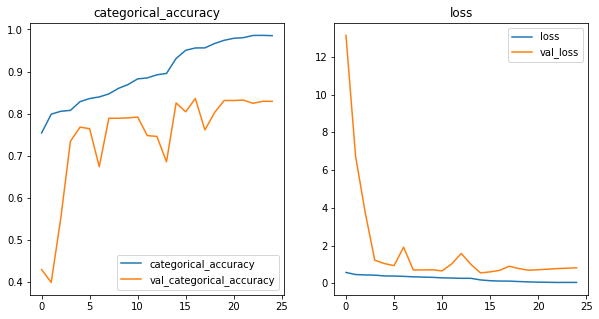

In [18]:
plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
plt.plot(history['categorical_accuracy'])
plt.plot(history['val_categorical_accuracy'])
plt.legend(['categorical_accuracy', 'val_categorical_accuracy'])
plt.title('categorical_accuracy')
plt.subplot(1,2,2)
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.title('loss')
plt.show()

#### Metrics

In [19]:
# load best model
model.load_weights('best.h5') 

In [20]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = np.array([])
y_true = np.array([])
for x_val, y_val in tqdm(gen_val):
    pred = model.predict(x_val)
    y_pred = np.append(y_pred, np.argmax(pred, axis=-1))
    y_true = np.append(y_true, np.argmax(y_val, axis=-1))

  0%|          | 0/17 [00:00<?, ?it/s]

In [21]:
# classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         0.0       0.86      1.00      0.93       254
         1.0       0.85      0.85      0.85       526
         2.0       0.72      0.61      0.66       264

    accuracy                           0.83      1044
   macro avg       0.81      0.82      0.81      1044
weighted avg       0.82      0.83      0.82      1044



In [22]:
# Confusion matrix:
#   row: Ground truth
#   column: predict
print(confusion_matrix(y_true, y_pred))

[[254   0   0]
 [ 17 446  63]
 [ 24  78 162]]


#### Make Kaggle Submission

In [23]:
predictions = np.argmax(model.predict(gen_test), axis=-1)

In [24]:
df = pd.DataFrame()
df['Id'] = [f'{i:05d}.jpeg' for i in range(len(img_paths_test))]
df['Category'] = predictions.astype(int)
df.to_csv('submission.csv', index=None)
df

,Id,Category
0,00000.jpeg,0
1,00001.jpeg,1
2,00002.jpeg,1
3,00003.jpeg,2
4,00004.jpeg,1
...,...,...
619,00619.jpeg,0
620,00620.jpeg,1
621,00621.jpeg,0
622,00622.jpeg,2


In [25]:
history

{'accuracy': [0.7543144822120667,
  0.798897385597229,
  0.8058485388755798,
  0.8080057501792908,
  0.8286193609237671,
  0.8360498547554016,
  0.8398849368095398,
  0.8470757603645325,
  0.8602588772773743,
  0.8693671822547913,
  0.8827900290489197,
  0.8849472403526306,
  0.8923777341842651,
  0.8957334756851196,
  0.931208074092865,
  0.9506232142448425,
  0.956136167049408,
  0.9563758373260498,
  0.9666826725006104,
  0.9743528366088867,
  0.9791467189788818,
  0.9805848598480225,
  0.9858580827713013,
  0.9860978126525879,
  0.9853787422180176],
 'categorical_accuracy': [0.7543144822120667,
  0.798897385597229,
  0.8058485388755798,
  0.8080057501792908,
  0.8286193609237671,
  0.8360498547554016,
  0.8398849368095398,
  0.8470757603645325,
  0.8602588772773743,
  0.8693671822547913,
  0.8827900290489197,
  0.8849472403526306,
  0.8923777341842651,
  0.8957334756851196,
  0.931208074092865,
  0.9506232142448425,
  0.956136167049408,
  0.9563758373260498,
  0.9666826725006104,
 